In [150]:
import numpy as np
import pandas as pd
import itertools
from Bio import SeqIO
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Wczytanie i przygotowanie danych

### Pliki `.bed`

In [2]:
negative_set = pd.read_csv('negative_set.bed', delimiter='\t', header=None, names=["Chromosome", "StartPos", "EndPos"])
positive_set = pd.read_csv('GM12878.bed', delimiter='\t', header=None, names=["Chromosome", "StartPos", "EndPos", "Score"])

In [3]:
negative_set.head(5)

,Chromosome,StartPos,EndPos
0,chr10,32251,36771
1,chr10,39431,39891
2,chr10,72312,74222
3,chr10,84717,85177
4,chr10,90499,91949


In [4]:
positive_set.head(5)

,Chromosome,StartPos,EndPos,Score
0,chr1,773300,774100,7.866088
1,chr1,778980,779450,6.472419
2,chr1,800100,802000,11.010675
3,chr1,825670,826410,6.114487
4,chr1,839470,842590,8.848865


In [5]:
# dodanie etykiety do zbiorów
negative_set["IsEnhancer"] = 0
positive_set["IsEnhancer"] = 1

positive_set = positive_set.drop(columns="Score")

In [6]:
# połączenie zbiorów danych
total_set = pd.concat([negative_set, positive_set])

# usunięcie nieprawidłowych chromosomów
total_set = total_set.loc[total_set["Chromosome"].str.match(r"chr\d+")]

total_set = total_set.reset_index(drop=True)

### Plik `.fasta`

In [11]:
# odczyt pliku za pomocą biblioteki biopython
plik = "GRCh37.primary_assembly.genome.fa"
#"GRCh37.primary_assembly.genome.fa"
fasta_sequences = {}

with open(plik, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        fasta_sequences[record.id] = record.seq

In [12]:
# mamy podział na chromosomy
list(fasta_sequences.keys())[:5]

['chr1', 'chr10', 'chr11', 'chr12', 'chr13']

In [24]:
# w każdym chromosomie mamy sekwencję DNA
fasta_sequences["chr1"]

Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN')

In [25]:
# na podstawie danych z plików .bed
# wybieramy odpowiednie fragmenty DNA (chromosom, pozycja początkowa i końcowa)

dna_sequence_list = []

for index, data in total_set.iterrows():
    chromosome = data["Chromosome"]
    start_pos = data["StartPos"]
    end_pos = data["EndPos"]
    dna_sequence = str(fasta_sequences[chromosome][start_pos:end_pos])
    dna_sequence_list.append(dna_sequence)

total_set["DNA sequence"] = dna_sequence_list

In [26]:
total_set.head(5)

,Chromosome,StartPos,EndPos,IsEnhancer,DNA sequence
0,chr10,32251,36771,0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,chr10,39431,39891,0,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,chr10,72312,74222,0,CTGCCACCGTGCCTGGCTAATTTCTGTATTTTTAGTAGAGAGGGGG...
3,chr10,84717,85177,0,AGAAGTTGAATCTCTGAATAGACCAATAACAGGATCTGAAATTGTG...
4,chr10,90499,91949,0,AGGTCAGGTGATCTGCAGCCAACCAAGCAGCTGCTAAGTGGCCAAC...


In [27]:
# usuwanie rekordów z 'N' w sekwencji DNA
total_set = total_set[~total_set["DNA sequence"].str.contains("N")]

### k-mery

In [28]:
# funkcja do zliczenia k-merów w sekwencji DNA
# dla całej ramki total_set
# i do zapisu zliczonych częstości do pliku
def count_and_save_kmers(k):

    # lista wszystkich k-merów
    kmers = [''.join(kmer_tuple) for kmer_tuple in itertools.product('ACTG', repeat=k)]

    # funkcja do odwracania k-merów
    def reverse_kmer(seq: str):
        mapping = {
            "A": "T",
            "T": "A",
            "C": "G",
            "G": "C",
        }
        return "".join([mapping[s] for s in seq[::-1]])

    # lista unikalnych k-merów, które (i których odwrócenia) będziemy zliczać
    # dla k=4 liczy 136 elementów
    unique_kmers = []
    for kmer in kmers:
        reversed_kmer = reverse_kmer(kmer)
        if kmer not in unique_kmers and reversed_kmer not in unique_kmers:
            unique_kmers.append(kmer)

    # słownik do zliczania k-merów
    kmers_counts = {kmer: pd.Series(index=total_set.index, data=0) for kmer in unique_kmers}

    # zliczamy k-mery
    for kmer in tqdm(kmers):
        if kmer in unique_kmers:  
            kmers_counts[kmer] += total_set["DNA sequence"].str.count(kmer)
        else:
            reversed_kmer = reverse_kmer(kmer)
            kmers_counts[reversed_kmer] = total_set["DNA sequence"].str.count(kmer)

    # łączymy częstości w ramkę danych
    kmers_counts_df = pd.concat(kmers_counts, axis=1).round(6)

    # dzielimy przez długość sekwencji
    kmers_counts_df = kmers_counts_df.div(total_set["DNA sequence"].str.len(), axis=0)

    # łączymy z pierwotną ramką total_set i zapisujemy do pliku 
    total_set_with_kmers = pd.concat([total_set, kmers_counts_df], axis=1)
    (
        total_set_with_kmers
            .drop(columns=["StartPos", "EndPos", "DNA sequence"])
            .to_parquet(f"total_set_k_mers/total_set_{k}_mer.gzip", compression="gzip", index=False)
    )

In [ ]:
# zliczamy częstości k-merów dla kilku wybranych k

# for k in [2, 3, 4, 5]:
#     count_and_save_kmers(k)

## Przygotowanie klasyfikatora

### Wczytanie zbiorów z policzonymi częstościami k-merów

In [135]:
# wczytanie i podział na zbiory treningowy i testowy

k = 3
total_set = pd.read_parquet(f"total_set_k_mers/total_set_{k}_mer.gzip")

test_set = total_set.loc[total_set["Chromosome"].isin(["chr1", "chr14", "chr21"])]
test_set_X = test_set.drop(columns=["Chromosome", "IsEnhancer"])
test_set_Y = test_set["IsEnhancer"]

trening_set = total_set.loc[~total_set["Chromosome"].isin(["chr1", "chr14", "chr21"])]
trening_set_X = trening_set.drop(columns=["Chromosome", "IsEnhancer"])
trening_set_Y = trening_set["IsEnhancer"]

#utworzenie zbioru walidacyjnego
X_train, X_val, y_train, y_val = train_test_split(
    trening_set_X, trening_set_Y, stratify=trening_set_Y, test_size=0.3, random_state=42
)

In [98]:
#zbiór testowy zawiera same Enhancery
test_set_Y.value_counts()

1    6990
Name: IsEnhancer, dtype: int64

Ponieważ zbiór testowy zawiera same enhancery, utworzono zbiór walidacyjny, o podobnym rozkładzie jak treningowy. (30% zbioru treningowego)

In [107]:
y_val.value_counts()

0    21717
1    12454
Name: IsEnhancer, dtype: int64

In [112]:
y_train.value_counts()

0    50672
1    29059
Name: IsEnhancer, dtype: int64

### Optymalizacja hiperparametrów
Wybrano RandomForestClassifier, i metodę random search

In [145]:
#Hiperparametry
n_estimators = [50, 100, 400]
max_features = ['log2', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_depth = [3, 7, 10, 15]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'max_depth': max_depth}


In [146]:
def train_classifier(k, random_grid):
    total_set = pd.read_parquet(f"total_set_k_mers/total_set_{k}_mer.gzip")

    test_set = total_set.loc[total_set["Chromosome"].isin(["chr1", "chr14", "chr21"])]
    test_set_X = test_set.drop(columns=["Chromosome", "IsEnhancer"])
    test_set_Y = test_set["IsEnhancer"]

    trening_set = total_set.loc[~total_set["Chromosome"].isin(["chr1", "chr14", "chr21"])]
    trening_set_X = trening_set.drop(columns=["Chromosome", "IsEnhancer"])
    trening_set_Y = trening_set["IsEnhancer"]
    
    #utworzenie zbioru walidacyjnego
    X_train, X_val, y_train, y_val = train_test_split(
        trening_set_X, trening_set_Y, stratify=trening_set_Y, test_size=0.3, random_state=42
    )
    print('start')
    model = RandomForestClassifier()
    model = RandomizedSearchCV(model, random_grid, random_state=13, n_iter=10, cv=3, verbose=3, scoring='roc_auc')
    model.fit(X_train, y_train)
    print('trained')
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_test = accuracy_score(y_val, model.predict(X_val))
    
    train_prob = model.predict_proba(X_train)
    test_prob = model.predict_proba(X_val)
    
    roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    roc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    return [accuracy_train, accuracy_test, roc_train, roc_val], train_prob, test_prob, model
    

In [147]:
w5, prob5, test_5_prob, model = train_classifier(5, random_grid)

start
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.0s
[CV 2/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.2s
[CV 3/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.5s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  47.4s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  48.1s
[CV 3/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  47.2s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  49.0s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, mi

In [164]:
w4, prob4, test_4_prob, model4 = train_classifier(4, random_grid)

start
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.4s
[CV 2/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.6s
[CV 3/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   5.2s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  34.0s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  33.1s
[CV 3/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  34.3s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.3s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, mi

In [165]:
w3, prob3, test_3_prob, model3 = train_classifier(3, random_grid)

start
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   4.2s
[CV 2/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   4.2s
[CV 3/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   4.2s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  16.1s
[CV 3/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  16.6s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, mi

In [166]:
w2, prob2, test_2_prob, model2 = train_classifier(2, random_grid)

start
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   2.9s
[CV 2/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   2.9s
[CV 3/3] END max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   2.9s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  10.7s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV 3/3] END max_depth=15, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV 1/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  10.8s
[CV 2/3] END max_depth=15, max_features=sqrt, min_samples_leaf=1, mi

### Porównanie modeli -  krzywe ROC

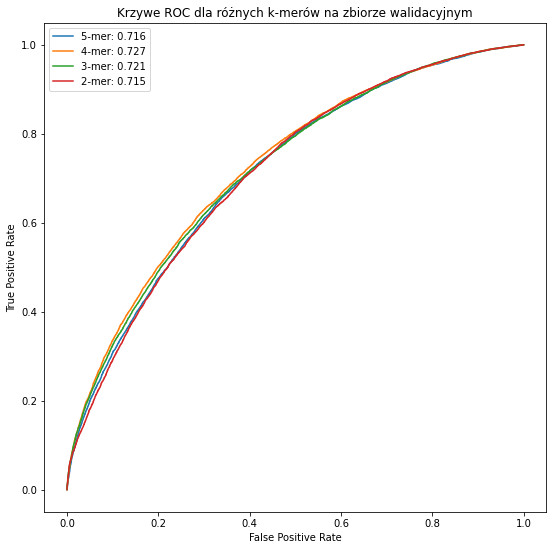

In [187]:
def plot_roc_curve(y_true, y_pred, name):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    score = round(roc_auc_score(y_true, y_pred), 3)
    name += ': ' + str(score)
    plt.plot(fpr, tpr, label=name)

plt.figure(figsize=(9,9))
# plot_roc_curve(trening_set_Y, prob5[:, 1], "5-mer")
# plot_roc_curve(trening_set_Y, prob4[:, 1], "4-mer")
# plot_roc_curve(trening_set_Y, prob3[:, 1], "3-mer")
# plot_roc_curve(trening_set_Y, prob2[:, 1], "2-mer")
plot_roc_curve(y_val, test_5_prob[:, 1], "5-mer")
plot_roc_curve(y_val, test_4_prob[:, 1], "4-mer")
plot_roc_curve(y_val, test_3_prob[:, 1], "3-mer")
plot_roc_curve(y_val, test_2_prob[:, 1], "2-mer")


plt.legend()
plt.title('Krzywe ROC dla różnych k-merów na zbiorze walidacyjnym')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
#plt.savefig('roc.png')

### Porównanie modeli - różne metryki

In [191]:
def score_dict(k, roc, model, ta, tr):
    total_set = pd.read_parquet(f"total_set_k_mers/total_set_{k}_mer.gzip")

    test_set = total_set.loc[total_set["Chromosome"].isin(["chr1", "chr14", "chr21"])]
    test_set_X = test_set.drop(columns=["Chromosome", "IsEnhancer"])
    test_set_Y = test_set["IsEnhancer"]

    trening_set = total_set.loc[~total_set["Chromosome"].isin(["chr1", "chr14", "chr21"])]
    trening_set_X = trening_set.drop(columns=["Chromosome", "IsEnhancer"])
    trening_set_Y = trening_set["IsEnhancer"]

    #utworzenie zbioru walidacyjnego
    X_train, X_val, y_train, y_val = train_test_split(
        trening_set_X, trening_set_Y, stratify=trening_set_Y, test_size=0.3, random_state=42
    )
    kdict = classification_report(y_val,model.predict(X_val), output_dict=True)
    test_acc = accuracy_score(test_set_Y, model.predict(test_set_X))
    return [roc, kdict['accuracy'], kdict['weighted avg']['precision'], kdict['weighted avg']['recall'],
                            kdict['weighted avg']['f1-score'], test_acc, ta, tr] 

In [192]:
indicators = ["roc auc", "accuracy","precison", "recall","f1","test_accuracy", "train accuracy", "train roc auc"]
table = pd.DataFrame(columns = indicators) 

table.loc['5-mer'] = score_dict(5, w5[-1], model, w5[0], w5[2])
table.loc['4-mer'] = score_dict(4, w4[-1], model4, w4[0], w4[2])
table.loc['3-mer'] = score_dict(3, w3[-1], model3, w3[0], w3[2])
table.loc['2-mer'] = score_dict(2, w2[-1], model2, w2[0], w2[2])

### Wyniki na zbiorze walidacyjnym

In [195]:
table.sort_values(by = 'roc auc', ascending = False)

,roc auc,accuracy,precison,recall,f1,test_accuracy,train accuracy,train roc auc
4-mer,0.727418,0.693541,0.686074,0.693541,0.661339,0.340629,0.912832,0.979051
3-mer,0.721336,0.690732,0.680825,0.690732,0.660990,0.350930,0.858662,0.948129
5-mer,0.716008,0.681689,0.673625,0.681689,0.639916,0.293562,0.914826,0.986655
2-mer,0.714681,0.681777,0.667559,0.681777,0.659245,0.387268,0.807202,0.896994


### Najlepszy model
Przetestowano las losowy, z różnymi hiperparametrami dla k=[2,3,4,5].

Ostatecznie najlepszy klasyfikator otrzymano dla k = 4, czyli 4-merów. Uzyskany wynik ROC AUC na zbiorze walidacyjnym to 0.727.
Najwięcej accuracy na zbiorze testowym(zawierającym same enhancery), to 0.387 (dla 2-merów). 